In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report
from sklearn.preprocessing import LabelEncoder

In [3]:
# Load dataset (fixed column names)
df = pd.read_csv("retail_store_inventory.csv", parse_dates=["Date"])

In [5]:
# Rename for easier handling
df = df.rename(columns={
    "Date": "date",
    "Store ID": "store_id",
    "Product ID": "product_id",
    "Category": "category",
    "Region": "region",
    "Inventory Level": "inventory_level",
    "Units Sold": "sales",
    "Weather Condition": "weather",
    "Holiday/Promotion": "holiday_promo"
})

In [6]:
# Sort by time
df = df.sort_values(["store_id", "product_id", "date"])

In [7]:
df["dayofweek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month

In [8]:
le = LabelEncoder()
for col in ["category", "region", "weather", "holiday_promo"]:
    df[col] = le.fit_transform(df[col].astype(str))

# Lag features
df["lag_1"] = df.groupby(["store_id", "product_id"])["sales"].shift(1)
df["lag_7"] = df.groupby(["store_id", "product_id"])["sales"].shift(7)
df["rolling_mean_7"] = df.groupby(["store_id", "product_id"])["sales"].shift(1).rolling(7).mean()
df["rolling_std_7"] = df.groupby(["store_id", "product_id"])["sales"].shift(1).rolling(7).std()


In [9]:
df = df.dropna()

In [12]:
features = ["dayofweek", "month", "category", "region", "weather", "holiday_promo",
            "lag_1", "lag_7", "rolling_mean_7", "rolling_std_7"]
X = df[features]
y = df["sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

# Evaluation (Regression)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


non_zero_idx = y_test > 0
mape = np.mean(np.abs((y_test[non_zero_idx] - y_pred[non_zero_idx]) / y_test[non_zero_idx])) * 100

print("\n Demand Forecasting Metrics:")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")



 Demand Forecasting Metrics:
MAE: 91.57, RMSE: 111.24, MAPE: 346.31%


In [15]:
df_test = X_test.copy()
df_test["actual_sales"] = y_test
df_test["predicted_sales"] = y_pred

# Pricing Rule
df_test["dynamic_price_factor"] = np.where(
    df_test["predicted_sales"] > df_test["predicted_sales"].median(), 1.1, 0.9
)

print("\n  Dynamic Pricing Adjustments:")
print(df_test[["predicted_sales", "dynamic_price_factor"]].head())



  Dynamic Pricing Adjustments:
      predicted_sales  dynamic_price_factor
780            155.99                   1.1
880            106.87                   0.9
980            125.46                   0.9
1080           159.39                   1.1
1180           134.57                   0.9


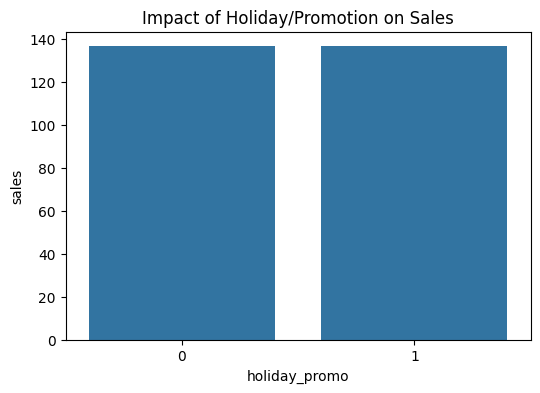


 Holiday/Promotion Impact (Average Sales):
   holiday_promo       sales
0              0  136.472958
1              1  136.537238


In [16]:
impact = df.groupby(["holiday_promo"])["sales"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=impact, x="holiday_promo", y="sales")
plt.title("Impact of Holiday/Promotion on Sales")
plt.show()

print("\n Holiday/Promotion Impact (Average Sales):")
print(impact)

In [17]:
df["predicted_sales"] = reg_model.predict(df[features])
df["stockout_risk"] = (df["inventory_level"] < df["predicted_sales"]).astype(int)

X_cls = df[features]
y_cls = df["stockout_risk"]

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, shuffle=False)

cls_model = RandomForestClassifier(n_estimators=100, random_state=42)
cls_model.fit(X_train_cls, y_train_cls)
y_pred_cls = cls_model.predict(X_test_cls)

print("\n Stockout Risk Classification Report:")
print(classification_report(y_test_cls, y_pred_cls, digits=3))


 Stockout Risk Classification Report:
              precision    recall  f1-score   support

           0      0.796     1.000     0.886     11520
           1      0.000     0.000     0.000      2960

    accuracy                          0.796     14480
   macro avg      0.398     0.500     0.443     14480
weighted avg      0.633     0.796     0.705     14480



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


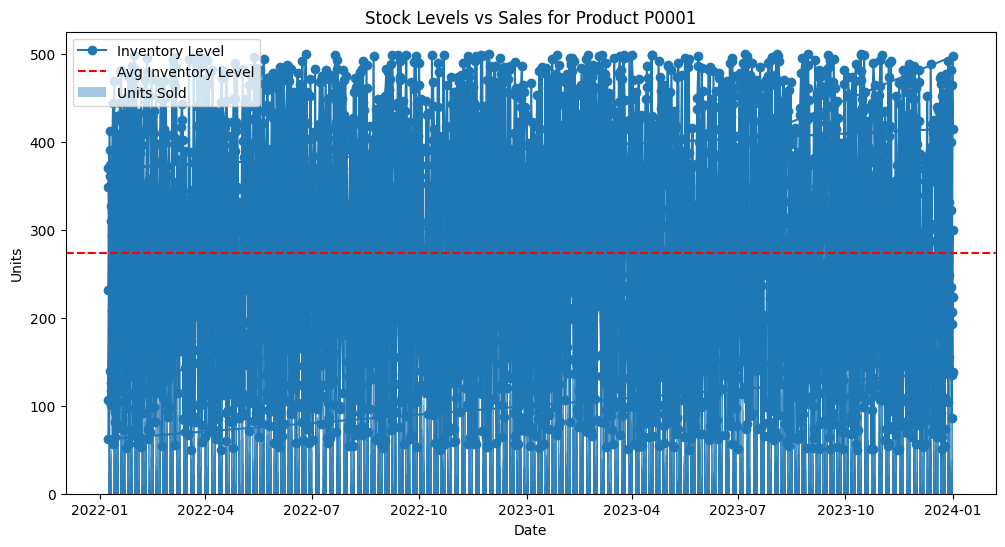

In [20]:
plt.figure(figsize=(12,6))
sample_product = df["product_id"].iloc[0]  # choose a sample product
df_sample = df[df["product_id"] == sample_product]

plt.plot(df_sample["date"], df_sample["inventory_level"], marker="o", label="Inventory Level")
plt.bar(df_sample["date"], df_sample["sales"], alpha=0.4, label="Units Sold")
plt.axhline(y=df_sample["inventory_level"].mean(), color="red", linestyle="--", label="Avg Inventory Level")
plt.title(f"Stock Levels vs Sales for Product {sample_product}")
plt.xlabel("Date")
plt.ylabel("Units")
plt.legend()
plt.show()

In [21]:
lead_time = 5  # business assumption (days)
safety_stock = 50  # buffer

avg_daily_demand = df["sales"].mean()
reorder_point = (avg_daily_demand * lead_time) + safety_stock

df["Reorder_Needed"] = df["inventory_level"].apply(lambda x: "Yes" if x < reorder_point else "No")

print("\n Reorder Alerts (sample 10 rows):")
print(df[["date", "product_id", "inventory_level", "sales", "Reorder_Needed"]].head(10))



 Reorder Alerts (sample 10 rows):
           date product_id  inventory_level  sales Reorder_Needed
700  2022-01-08      P0001              231      2            Yes
800  2022-01-09      P0001              373    350            Yes
900  2022-01-10      P0001              327     36            Yes
1000 2022-01-11      P0001              101     16            Yes
1100 2022-01-12      P0001              145    104            Yes
1200 2022-01-13      P0001              110     80            Yes
1300 2022-01-14      P0001              199    177            Yes
1400 2022-01-15      P0001              290    176            Yes
1500 2022-01-16      P0001              104     97            Yes
1600 2022-01-17      P0001              134     69            Yes


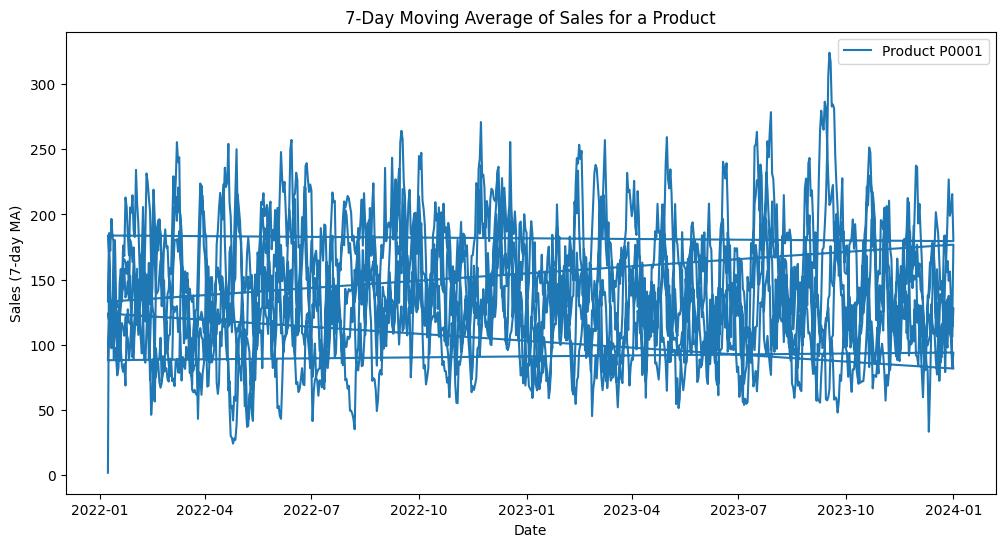

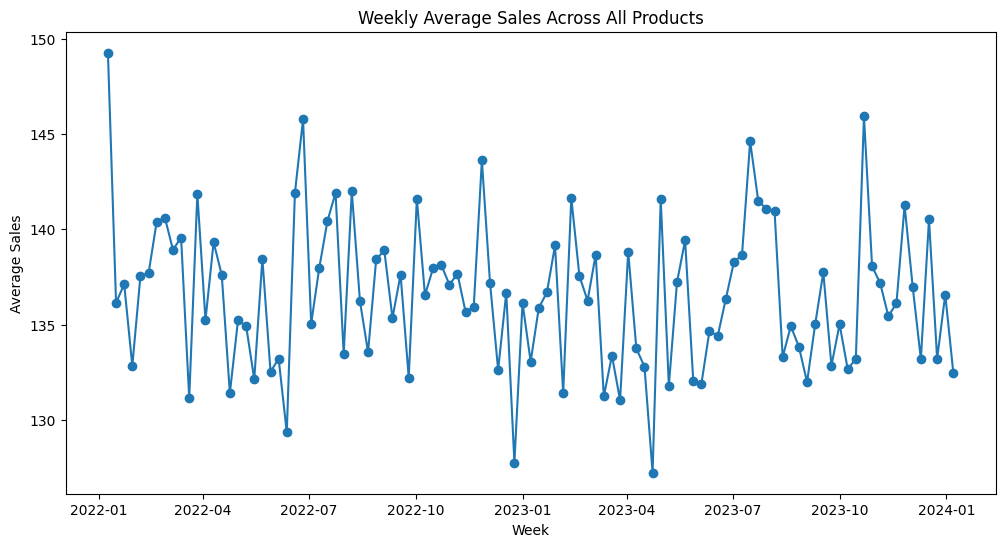

In [25]:
df["sales_ma7"] = df.groupby("product_id")["sales"].transform(lambda x: x.rolling(7, min_periods=1).mean())

plt.figure(figsize=(12,6))
subset = df[df["product_id"] == df["product_id"].iloc[0]]
plt.plot(subset["date"], subset["sales_ma7"], label=f"Product {subset['product_id'].iloc[0]}")
plt.title("7-Day Moving Average of Sales for a Product")
plt.xlabel("Date")
plt.ylabel("Sales (7-day MA)")
plt.legend()
plt.show()

weekly_sales = df.groupby(pd.Grouper(key="date", freq="W"))["sales"].mean().reset_index()
plt.figure(figsize=(12,6))
plt.plot(weekly_sales["date"], weekly_sales["sales"], marker="o")
plt.title("Weekly Average Sales Across All Products")
plt.xlabel("Week")
plt.ylabel("Average Sales")
plt.show()
